In [1]:
from smach_utils2 import *


[ WARN] [1686105947.613785145, 2376.798000000]: Link hand_l_finger_vacuum_frame has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1686105947.619698658, 2376.799000000]: Link head_l_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1686105947.620026096, 2376.799000000]: Link head_r_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1686105947.627884439, 2376.799000000]: Group state 'neutral' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1686105947.628142376, 2376.799000000]: Group state 'go' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.

In [20]:
joint_names    = rospy.get_param("~joint_names", [])
max_iterations = rospy.get_param("~max_iterations", 20)
print(prompt+"Joint names: " + str(joint_names))
print(prompt+"max_iterations: " + str(max_iterations))1

Joint names: ['arm_lift_joint', 'arm_flex_joint', 'arm_roll_joint', 'wrist_flex_joint', 'wrist_roll_joint']
max_iterations: 20


In [21]:
get_model_info(joint_names)

Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='base_transmission']/actuator[@name='base_r_drive_wheel_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='base_transmission']/actuator[@name='base_l_drive_wheel_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='base_roll_joint_transmission']/actuator[@name='base_roll_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='head_pan_joint_transmission']/actuator[@name='head_pan_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='head_tilt_joint_transmission']/actuator[@name='head_tilt_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='arm_lift_joint_transmission']/actuator[@name='arm_lift_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='arm_flex_joint_transmission']/ac

([<urdf_parser_py.urdf.Joint at 0x7f019af3f3d0>,
 [array([[1.  , 0.  , 0.  , 0.  ],
         [0.  , 1.  , 0.  , 0.  ],
         [0.  , 0.  , 1.  , 0.34],
         [0.  , 0.  , 0.  , 1.  ]]),
  array([[1.   , 0.   , 0.   , 0.141],
         [0.   , 1.   , 0.   , 0.078],
         [0.   , 0.   , 1.   , 0.   ],
         [0.   , 0.   , 0.   , 1.   ]]),
  array([[1.   , 0.   , 0.   , 0.005],
         [0.   , 1.   , 0.   , 0.   ],
         [0.   , 0.   , 1.   , 0.345],
         [0.   , 0.   , 0.   , 1.   ]]),
  array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]),
  array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]])])

In [ ]:
#!/usr/bin/env python
import math
import sys
import rospy
import numpy
import tf
import tf.transformations as tft
import urdf_parser_py.urdf
from std_msgs.msg import Float64MultiArray
from manip_msgs.srv import *
from trajectory_msgs.msg import JointTrajectory, JointTrajectoryPoint



"""
    para 17 de febrero revisar la cinematica inversa y corregirla si es posible
"""

prompt = ""

def get_model_info(joint_names):
    robot_model = urdf_parser_py.urdf.URDF.from_parameter_server()
    joints = []
    transforms = []
    for name in joint_names:
        for joint in robot_model.joints:
            if joint.name == name:
                joints.append(joint)
    for joint in joints:
        T = tft.translation_matrix(joint.origin.xyz)
        R = tft.euler_matrix(joint.origin.rpy[0], joint.origin.rpy[1], joint.origin.rpy[2])
        transforms.append(tft.concatenate_matrices(T,R))
    return joints, transforms

def angles_in_joint_limits(q):
    for i in range(len(q)):
        if q[i] < joints[i].limit.lower or q[i] > joints[i].limit.upper:
            #print(prompt+"Articular position out of joint bounds")
            return False
    return True
    
def forward_kinematics(q):
    global transforms, joints
    H = tft.identity_matrix()
    for i in range(len(q)):
        H  = tft.concatenate_matrices(H, transforms[i], tft.rotation_matrix(q[i], joints[i].axis))
    H  = tft.concatenate_matrices(H, transforms[7])
    return numpy.asarray([H[0,3], H[1,3], H[2,3]] + list(tft.euler_from_matrix(H)))

def jacobian(q):
    delta_q = 0.000001   
    J = numpy.asarray([[0.0 for a in q] for i in range(6)])##numpy, ndarray
    qn = numpy.asarray([q,]*len(q)) + delta_q*numpy.identity(len(q))
    qp = numpy.asarray([q,]*len(q)) - delta_q*numpy.identity(len(q)) 
    for i in range(len(q)):
        J[:,i] = (forward_kinematics(qn[i]) - forward_kinematics(qp[i]))/delta_q/2.0
     
    return J

def inverse_kinematics(x, y, z, roll, pitch, yaw, initial_guess=numpy.zeros(7), max_iterations=20):
    only_xyz = math.isnan(roll) or math.isnan(pitch) or math.isnan(yaw)
    q = [qi for qi in initial_guess]
    pd = numpy.asarray([x,y,z,roll,pitch,yaw])
    p  = forward_kinematics(q)
    iterations = 0
    err = p-pd
    if only_xyz:
        err = err[0:3]
    while numpy.linalg.norm(err) > 0.00001 and iterations < max_iterations:
        J = jacobian(q)
        err = p - pd
        if only_xyz:
            J = J[0:3]
            err = err[0:3]
        else:
            err[3:6] = (err[3:6] + math.pi)%(2*math.pi) - math.pi
        q = (q - numpy.dot(numpy.linalg.pinv(J), err) + math.pi)%(2*math.pi) - math.pi
        p = forward_kinematics(q)
        err = p - pd
        if only_xyz:
            err = err[0:3]
        iterations +=1
    return iterations < max_iterations and angles_in_joint_limits(q), q

def get_polynomial_trajectory(q_initial, q_final, qp_initial=0, qp_final=0, qpp_initial=0, qpp_final=0, duration=1.0, time_step=0.05):
    #
    # This function calculates a polynomial trajectory for a single variable.
    # It is intended to be called N times for a N-DoF trajectory. 
    #
    t = duration
    A = [[   t**5,    t**4,   t**3, t**2, t, 1],
         [ 5*t**4,  4*t**3, 3*t**2,  2*t, 1, 0],
         [20*t**3, 12*t**2,    6*t,    2, 0, 0],
         [      0,       0,      0,    0, 0, 1],
         [      0,       0,      0,    0, 1, 0],
         [      0,       0,      0,    2, 0, 0]]
    A = numpy.asarray(A)
    B = [[q_final  ],
         [qp_final ],
         [qpp_final],
         [q_initial  ],
         [qp_initial ],
         [qpp_initial]]
    B = numpy.asarray(B)
    X = numpy.dot(numpy.linalg.inv(A),B)
    a5, a4, a3, a2, a1, a0 = X[0,0], X[1,0], X[2,0], X[3,0], X[4,0], X[5,0]
    T = numpy.arange(0, t, time_step)
    Q = numpy.zeros(len(T))
    for i in range(len(T)):
        Q[i] = a5*T[i]**5 + a4*T[i]**4 + a3*T[i]**3 + a2*T[i]**2 + a1*T[i] + a0

    return T, Q
    
def get_polynomial_trajectory_multi_dof(Q_start, Q_end, Qp_start=[], Qp_end=[], Qpp_start=[], Qpp_end=[], duration=1.0, time_step=0.05):
    Q = []
    T = []
    if Qp_start == []:
        Qp_start = numpy.zeros(len(Q_start))
    if Qpp_start == []:
        Qpp_start = numpy.zeros(len(Q_start))
    if Qp_end == []:
        Qp_end = numpy.zeros(len(Q_end))
    if Qpp_end == []:
        Qpp_end = numpy.zeros(len(Q_end))
    for i in range(len(Q_start)):
        T, Qi = get_polynomial_trajectory(Q_start[i], Q_end[i], Qp_start[i], Qp_end[i], Qpp_start[i], Qpp_end[i], duration, time_step)
        Q.append(Qi)
    Q = numpy.asarray(Q)
    Q = Q.transpose()
    return Q,T

def callback_forward_kinematics(req):
    if len(req.q) != 7:
        print(prompt+"By the moment, only 7-DOF arm is supported")
        return False
    resp = ForwardKinematicsResponse()
    resp.x, resp.y, resp.z, resp.roll, resp.pitch, resp.yaw = forward_kinematics(req.q)
    return resp

def get_trajectory_time(p1, p2, speed_factor):
    p1 = numpy.asarray(p1)
    p2 = numpy.asarray(p2)
    m = max(numpy.absolute(p1 - p2))
    return m/speed_factor + 0.5

def callback_ik_for_trajectory(req):
    
    global max_iterations
    # entra una Pose
    print(prompt+"Calculating inverse kinematics and trajectory for " + str([req.x, req.y, req.z, req.roll, req.pitch, req.yaw]))
    # si no hay suposicion inicial toma la pose actual de brazo
    if len(req.initial_guess) <= 0 or req.initial_guess == None:
        initial_guess = rospy.wait_for_message("/hardware/arm/current_pose", Float64MultiArray)
        initial_guess = initial_guess.data
    else:
        initial_guess = req.initial_guess

    # obtenemos la pose supuesta a cinematica directa, es el punto inicial
    p1 = forward_kinematics(initial_guess)
    # el punto final de la trayectoria es el punto o pose objetivo
    p2 = [req.x, req.y, req.z, req.roll, req.pitch, req.yaw]
    t  = req.duration if req.duration > 0 else get_trajectory_time(p1, p2, 0.25)
    dt = req.time_step if req.time_step > 0 else 0.05
    # obtiene la trayectoria que lleva de punto inicial a punto final (objetivo)
    X,T = get_polynomial_trajectory_multi_dof(p1, p2, duration=t, time_step=dt)
    trj = JointTrajectory()
    trj.header.stamp = rospy.Time.now()
    q = initial_guess
    for i in range(len(X)): # para cada ....
        x, y, z, roll, pitch, yaw = X[i]    # punto de la trayectoria en espacio cartesiano
        # ik para cada punto de la trayectoria
        success, q = inverse_kinematics(x, y, z, roll, pitch, yaw, q, max_iterations)  
        if not success:
            return False
        p = JointTrajectoryPoint()
        p.positions = q
        p.time_from_start = rospy.Duration.from_sec(T[i])
        trj.points.append(p)
    resp = InverseKinematicsPose2TrajResponse()
    resp.articular_trajectory = trj
    return resp
    
        
def callback_ik_for_pose(req):
    global max_iterations
    print(prompt+"Calculating inverse kinematics for pose: " + str([req.x, req.y, req.z, req.roll, req.pitch, req.yaw]))
    if len(req.initial_guess) <= 0 or req.initial_guess == None:
        initial_guess = rospy.wait_for_message("/hardware/arm/current_pose", Float64MultiArray, 5.0)
        initial_guess = initial_guess.data
    else:
        initial_guess = req.initial_guess
    resp = InverseKinematicsPose2PoseResponse()
    success, q = inverse_kinematics(req.x, req.y, req.z, req.roll, req.pitch, req.yaw, initial_guess, max_iterations)
    if not success:
        return False
    resp.q = q
    return resp        
    

def main():
    global joint_names, max_iterations, joints, transforms, prompt
    print("INITIALIZING INVERSE KINEMATIC NODE BY MARCOSOFT...")
    rospy.init_node("ik_geometric")
    prompt = rospy.get_name().upper() + ".->"
    joint_names    = rospy.get_param("~joint_names", [])
    max_iterations = rospy.get_param("~max_iterations", 20)
    print(prompt+"Joint names: " + str(joint_names))
    print(prompt+"max_iterations: " + str(max_iterations))

    joints, transforms = get_model_info(joint_names)
    if not (len(joints) > 6 and len(transforms) > 6):
        print("Inverse kinematics.->Cannot get model info from parameter server")
        sys.exit(-1)

    rospy.Service("/manipulation/forward_kinematics"   , ForwardKinematics, callback_forward_kinematics)    
    rospy.Service("/manipulation/ik_trajectory"        , InverseKinematicsPose2Traj, callback_ik_for_trajectory)
    rospy.Service("/manipulation/ik_pose"              , InverseKinematicsPose2Pose, callback_ik_for_pose)
    loop = rospy.Rate(10)
    while not rospy.is_shutdown():
        loop.sleep()

if __name__ == '__main__':
    main()




In [5]:
import math
import sys
import rospy
import numpy
import tf
import tf.transformations as tft
import urdf_parser_py.urdf
from std_msgs.msg import Float64MultiArray

from trajectory_msgs.msg import JointTrajectory, JointTrajectoryPoint



"""
    para 17 de febrero revisar la cinematica inversa y corregirla si es posible
"""

prompt = ""

def get_model_info(joint_names):
    robot_model = urdf_parser_py.urdf.URDF.from_parameter_server()
    joints = []
    transforms = []
    for name in joint_names:
        for joint in robot_model.joints:
            if joint.name == name:
                joints.append(joint)
    for joint in joints:
        T = tft.translation_matrix(joint.origin.xyz)
        R = tft.euler_matrix(joint.origin.rpy[0], joint.origin.rpy[1], joint.origin.rpy[2])
        transforms.append(tft.concatenate_matrices(T,R))
    return joints, transforms

def angles_in_joint_limits(q):
    for i in range(len(q)):
        if q[i] < joints[i].limit.lower or q[i] > joints[i].limit.upper:
            #print(prompt+"Articular position out of joint bounds")
            return False
    return True
    
def forward_kinematics(q):
    global transforms, joints
    H = tft.identity_matrix()
    for i in range(len(q)):
        H  = tft.concatenate_matrices(H, transforms[i], tft.rotation_matrix(q[i], joints[i].axis))
    H  = tft.concatenate_matrices(H, transforms[7])
    return numpy.asarray([H[0,3], H[1,3], H[2,3]] + list(tft.euler_from_matrix(H)))

def jacobian(q):
    delta_q = 0.000001   
    J = numpy.asarray([[0.0 for a in q] for i in range(6)])##numpy, ndarray
    qn = numpy.asarray([q,]*len(q)) + delta_q*numpy.identity(len(q))
    qp = numpy.asarray([q,]*len(q)) - delta_q*numpy.identity(len(q)) 
    for i in range(len(q)):
        J[:,i] = (forward_kinematics(qn[i]) - forward_kinematics(qp[i]))/delta_q/2.0
     
    return J

def inverse_kinematics(x, y, z, roll, pitch, yaw, initial_guess=numpy.zeros(7), max_iterations=20):
    only_xyz = math.isnan(roll) or math.isnan(pitch) or math.isnan(yaw)
    q = [qi for qi in initial_guess]
    pd = numpy.asarray([x,y,z,roll,pitch,yaw])
    p  = forward_kinematics(q)
    iterations = 0
    err = p-pd
    if only_xyz:
        err = err[0:3]
    while numpy.linalg.norm(err) > 0.00001 and iterations < max_iterations:
        J = jacobian(q)
        err = p - pd
        if only_xyz:
            J = J[0:3]
            err = err[0:3]
        else:
            err[3:6] = (err[3:6] + math.pi)%(2*math.pi) - math.pi
        q = (q - numpy.dot(numpy.linalg.pinv(J), err) + math.pi)%(2*math.pi) - math.pi
        p = forward_kinematics(q)
        err = p - pd
        if only_xyz:
            err = err[0:3]
        iterations +=1
    return iterations < max_iterations and angles_in_joint_limits(q), q

def get_polynomial_trajectory(q_initial, q_final, qp_initial=0, qp_final=0, qpp_initial=0, qpp_final=0, duration=1.0, time_step=0.05):
    #
    # This function calculates a polynomial trajectory for a single variable.
    # It is intended to be called N times for a N-DoF trajectory. 
    #
    t = duration
    A = [[   t**5,    t**4,   t**3, t**2, t, 1],
         [ 5*t**4,  4*t**3, 3*t**2,  2*t, 1, 0],
         [20*t**3, 12*t**2,    6*t,    2, 0, 0],
         [      0,       0,      0,    0, 0, 1],
         [      0,       0,      0,    0, 1, 0],
         [      0,       0,      0,    2, 0, 0]]
    A = numpy.asarray(A)
    B = [[q_final  ],
         [qp_final ],
         [qpp_final],
         [q_initial  ],
         [qp_initial ],
         [qpp_initial]]
    B = numpy.asarray(B)
    X = numpy.dot(numpy.linalg.inv(A),B)
    a5, a4, a3, a2, a1, a0 = X[0,0], X[1,0], X[2,0], X[3,0], X[4,0], X[5,0]
    T = numpy.arange(0, t, time_step)
    Q = numpy.zeros(len(T))
    for i in range(len(T)):
        Q[i] = a5*T[i]**5 + a4*T[i]**4 + a3*T[i]**3 + a2*T[i]**2 + a1*T[i] + a0

    return T, Q
    
def get_polynomial_trajectory_multi_dof(Q_start, Q_end, Qp_start=[], Qp_end=[], Qpp_start=[], Qpp_end=[], duration=1.0, time_step=0.05):
    Q = []
    T = []
    if Qp_start == []:
        Qp_start = numpy.zeros(len(Q_start))
    if Qpp_start == []:
        Qpp_start = numpy.zeros(len(Q_start))
    if Qp_end == []:
        Qp_end = numpy.zeros(len(Q_end))
    if Qpp_end == []:
        Qpp_end = numpy.zeros(len(Q_end))
    for i in range(len(Q_start)):
        T, Qi = get_polynomial_trajectory(Q_start[i], Q_end[i], Qp_start[i], Qp_end[i], Qpp_start[i], Qpp_end[i], duration, time_step)
        Q.append(Qi)
    Q = numpy.asarray(Q)
    Q = Q.transpose()
    return Q,T

def callback_forward_kinematics(req):
    if len(req.q) != 7:
        print(prompt+"By the moment, only 7-DOF arm is supported")
        return False
    resp = ForwardKinematicsResponse()
    resp.x, resp.y, resp.z, resp.roll, resp.pitch, resp.yaw = forward_kinematics(req.q)
    return resp

def get_trajectory_time(p1, p2, speed_factor):
    p1 = numpy.asarray(p1)
    p2 = numpy.asarray(p2)
    m = max(numpy.absolute(p1 - p2))
    return m/speed_factor + 0.5

def callback_ik_for_trajectory(req):
    
    global max_iterations
    # entra una Pose
    print(prompt+"Calculating inverse kinematics and trajectory for " + str([req.x, req.y, req.z, req.roll, req.pitch, req.yaw]))
    # si no hay suposicion inicial toma la pose actual de brazo
    if len(req.initial_guess) <= 0 or req.initial_guess == None:
        initial_guess = rospy.wait_for_message("/hardware/arm/current_pose", Float64MultiArray)
        initial_guess = initial_guess.data
    else:
        initial_guess = req.initial_guess

    # obtenemos la pose supuesta a cinematica directa, es el punto inicial
    p1 = forward_kinematics(initial_guess)
    # el punto final de la trayectoria es el punto o pose objetivo
    p2 = [req.x, req.y, req.z, req.roll, req.pitch, req.yaw]
    t  = req.duration if req.duration > 0 else get_trajectory_time(p1, p2, 0.25)
    dt = req.time_step if req.time_step > 0 else 0.05
    # obtiene la trayectoria que lleva de punto inicial a punto final (objetivo)
    X,T = get_polynomial_trajectory_multi_dof(p1, p2, duration=t, time_step=dt)
    trj = JointTrajectory()
    trj.header.stamp = rospy.Time.now()
    q = initial_guess
    for i in range(len(X)): # para cada ....
        x, y, z, roll, pitch, yaw = X[i]    # punto de la trayectoria en espacio cartesiano
        # ik para cada punto de la trayectoria
        success, q = inverse_kinematics(x, y, z, roll, pitch, yaw, q, max_iterations)  
        if not success:
            return False
        p = JointTrajectoryPoint()
        p.positions = q
        p.time_from_start = rospy.Duration.from_sec(T[i])
        trj.points.append(p)
    resp = InverseKinematicsPose2TrajResponse()
    resp.articular_trajectory = trj
    return resp
    
        
def callback_ik_for_pose(req):
    global max_iterations
    print(prompt+"Calculating inverse kinematics for pose: " + str([req.x, req.y, req.z, req.roll, req.pitch, req.yaw]))
    if len(req.initial_guess) <= 0 or req.initial_guess == None:
        initial_guess = rospy.wait_for_message("/hardware/arm/current_pose", Float64MultiArray, 5.0)
        initial_guess = initial_guess.data
    else:
        initial_guess = req.initial_guess
    resp = InverseKinematicsPose2PoseResponse()
    success, q = inverse_kinematics(req.x, req.y, req.z, req.roll, req.pitch, req.yaw, initial_guess, max_iterations)
    if not success:
        return False
    resp.q = q
    return resp        
    


[ WARN] [1677532083.849866396, 93.202000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 93.202000 according to authority unknown_publisher
[ WARN] [1677532083.852442260, 93.202000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 93.202000 according to authority /pose_integrator
[ WARN] [1677532083.852543477, 93.202000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 93.202000 according to authority /pose_integrator
[ WARN] [1677532083.852577887, 93.202000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 93.202000 according to authority /pose_integrator
[ WARN] [1677532083.852607587, 93.202000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 93.202000 according to authority /pose_integrator
[ WARN] [1677532100.316520443, 94.485000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time

In [8]:
joint_names    = rospy.get_param("~joint_names", [])

[ WARN] [1677532271.652047252, 109.342000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 109.342000 according to authority unknown_publisher
[ WARN] [1677532271.656049207, 109.342000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 109.342000 according to authority /pose_integrator
[ WARN] [1677532271.656115621, 109.342000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 109.342000 according to authority /pose_integrator
[ WARN] [1677532271.656139866, 109.342000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 109.342000 according to authority /pose_integrator
[ WARN] [1677532271.656159559, 109.342000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 109.342000 according to authority /pose_integrator


In [9]:
joint_names

[]

[ WARN] [1677532282.096172516, 110.457000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 110.457000 according to authority unknown_publisher
[ WARN] [1677532282.096310736, 110.457000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 110.457000 according to authority /pose_integrator
[ WARN] [1677532282.096347637, 110.457000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 110.457000 according to authority /pose_integrator
[ WARN] [1677532282.096371259, 110.457000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 110.457000 according to authority /pose_integrator
[ WARN] [1677532282.096392054, 110.457000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 110.457000 according to authority /pose_integrator
[ WARN] [1677532301.166205581, 112.545000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame o

In [6]:
robot_model = urdf_parser_py.urdf.URDF.from_parameter_server()

Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='base_transmission']/actuator[@name='base_r_drive_wheel_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='base_transmission']/actuator[@name='base_l_drive_wheel_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='base_roll_joint_transmission']/actuator[@name='base_roll_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='head_pan_joint_transmission']/actuator[@name='head_pan_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='head_tilt_joint_transmission']/actuator[@name='head_tilt_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='arm_lift_joint_transmission']/actuator[@name='arm_lift_joint_actuator']
Unknown tag "hardwareInterface" in /robot[@name='hsrb']/transmission[@name='arm_flex_joint_transmission']/ac

In [11]:
robot_model.joints.

<function list.extend(iterable, /)>

In [13]:
for joint in robot_model.joints:
    print (joint.name)

base_footprint_joint
base_roll_joint
base_r_drive_wheel_joint
base_l_drive_wheel_joint
base_r_passive_wheel_x_frame_joint
base_r_passive_wheel_y_frame_joint
base_r_passive_wheel_z_joint
base_l_passive_wheel_x_frame_joint
base_l_passive_wheel_y_frame_joint
base_l_passive_wheel_z_joint
base_range_sensor_joint
base_imu_frame_joint
base_f_bumper_joint
base_b_bumper_joint
torso_lift_joint
head_pan_joint
head_tilt_joint
head_l_stereo_camera_joint
head_l_stereo_camera_gazebo_frame_joint
head_r_stereo_camera_joint
head_r_stereo_camera_gazebo_frame_joint
head_center_camera_frame_joint
head_center_camera_gazebo_frame_joint
head_rgbd_sensor_joint
head_rgbd_sensor_gazebo_frame_joint
arm_lift_joint
arm_flex_joint
arm_roll_joint
wrist_flex_joint
wrist_roll_joint
wrist_ft_sensor_frame_inverse_joint
wrist_ft_sensor_frame_joint
hand_palm_joint
hand_motor_joint
hand_l_proximal_joint
hand_l_spring_proximal_joint
hand_l_mimic_distal_joint
hand_l_distal_joint
hand_l_finger_tip_frame_joint
hand_l_finger_vac

In [19]:
rospy.get_param("~joint_names", [])

['arm_lift_joint',
 'arm_flex_joint',
 'arm_roll_joint',
 'wrist_flex_joint',
 'wrist_roll_joint']

In [18]:

rospy.set_param("~joint_names", ["arm_lift_joint",
"arm_flex_joint",
"arm_roll_joint",
"wrist_flex_joint",
"wrist_roll_joint"])

In [1]:
import numpy as np

In [5]:
(190+180)%360


10

In [1]:
import tensorflow


2023-03-03 14:15:49.178919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: initialization failed

In [1]:
from smach_utils2 import *

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'
[ WARN] [1678668004.529397639]: Link hand_l_finger_vacuum_frame has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1678668004.546842425, 2367.138000000]: Link head_l_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1678668004.548284446, 2367.138000000]: Link head_r_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1678668004.551369651, 2367.138000000]: Group state 'neutral' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1678668004.552195347, 2367.138000000]: Group state 'go' doesn't specify all group joints i

In [3]:
from nav_msgs.msg import OccupancyGrid
#

[ WARN] [1678658286.727390780]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2287.102000 according to authority /pose_integrator
[ WARN] [1678658286.727450321]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2287.102000 according to authority /pose_integrator
[ WARN] [1678658286.727477231]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2287.102000 according to authority /pose_integrator
[ WARN] [1678658286.727500771]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2287.102000 according to authority /pose_integrator
[ WARN] [1678658286.728171769]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2287.102000 according to authority unknown_publisher


In [2]:
inflated_map= np.asarray(map_msg.data)

In [5]:
import pickle

In [6]:
with open('/home/oscar/Desktop/img_map.pkl', 'wb') as f:  # open a text file
    pickle.dump(img,f)

NameError: name 'img' is not defined

In [7]:
##UNPÏCKLE
with open('/home/oscar/Desktop/img_map.pkl', 'rb') as f:

    img2 = pickle.load(f) # deserialize using load()

EOFError: Ran out of input

[ WARN] [1678658293.520413442]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2287.701000 according to authority /pose_integrator
[ WARN] [1678658293.520458639]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2287.701000 according to authority /pose_integrator
[ WARN] [1678658293.520490441]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2287.701000 according to authority /pose_integrator
[ WARN] [1678658293.520513176]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2287.701000 according to authority /pose_integrator
[ WARN] [1678658293.520841378]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2287.701000 according to authority unknown_publisher


In [11]:
img= map_msg

In [6]:

from nav_msgs.msg import OccupancyGrid
map_msg= rospy.wait_for_message('/augmented_map', OccupancyGrid)

inflated_map= np.asarray(map_msg.data)

In [9]:
import matplotlib.pyplot as plt


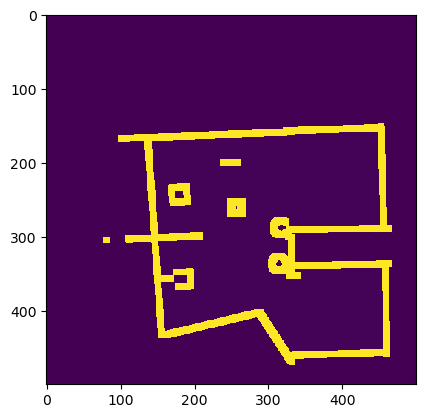

In [12]:
import matplotlib.pyplot as plt

img_map=inflated_map.reshape((img.info.width,img.info.height))

plt.imshow (img_map[750:1250,750:1250])

In [13]:
pix_per_m=img.info.resolution
point_origin=np.asarray((img.info.origin.position.x,img.info.origin.position.y))
map_quat= img.info.origin.orientation

In [14]:
def draw_at (px,py, contoured):
    contoured[px-5:px+5,py-5:py+5]=200
    return contoured
    

[ WARN] [1678658348.022475877]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2292.855000 according to authority unknown_publisher
[ WARN] [1678658348.022537335]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2292.855000 according to authority /pose_integrator
[ WARN] [1678658348.022592652]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2292.855000 according to authority /pose_integrator
[ WARN] [1678658348.022620471]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2292.855000 according to authority /pose_integrator
[ WARN] [1678658348.022648684]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2292.855000 according to authority /pose_integrator


In [196]:
img_map=inflated_map.reshape((map_msg.info.width,map_msg.info.height))


pix_per_m=map_msg.info.resolution
def get_robot_px():
    trans, rot=tf_man.getTF('base_link')
    robot=np.asarray(trans[:2])
    print (trans)
    return np.asarray((robot/pix_per_m).round(),dtype='int')


def check_point_map(x,y):
    # Quiero saber punto 0,-7 m esta libre?
    ##meters, map (not pixels)
    #x,y=0.2,8
    xrob,yrob=get_robot_px()
    safe_xy=np.asarray((x,-1*y))
    safe_xy_px=point_to_px (x,y)
    delta_px=  safe_xy_px-np.asarray((xrob,yrob))
    delta_px= delta_px / np.linalg.norm(delta_px).round()
    delta_px=np.round(delta_px*10)
    newxy=np.zeros(2)
    
    for i in range(9):
        if (contoured[1024+ safe_xy_px[1].astype('int'),1024-safe_xy_px[0].astype('int')]!=0):   ## axis are twisted cause y sign
                    print ('not safe at', safe_xy_px , safe_xy_px*pix_per_m)
                    draw_at(1024-safe_xy_px[1].astype('int'),1024+ safe_xy_px[0].astype('int'),contoured)
                    #draw_at(1024+safe_xy_px[1].astype('int'),1024- safe_xy_px[0].astype('int'),contoured)
                    xrob,yrob=get_robot_px()
                    delta_px=  safe_xy_px-np.asarray((xrob,yrob))
                    delta_px= delta_px / np.linalg.norm(delta_px).round()
                    delta_px=np.round(delta_px*10)


                    newxy[0]=safe_xy_px[0]-delta_px[0].astype('int')
                    newxy[1]=safe_xy_px[1]-delta_px[1].astype('int')
                    safe_xy_px=newxy
        else:
                print ('safe at', safe_xy_px, safe_xy_px*pix_per_m)
                return (safe_xy_px)
    

def point_to_px(x,y):
    safe_xy=np.asarray((x,y))
    return np.round(safe_xy/pix_per_m).astype('int')
def px_to_point(px,py):

    return np.asarray((px,py))*pix_per_m

    
    
    


contours, hierarchy = cv2.findContours(img_map.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contoured=cv2.drawContours(img_map.astype('uint8'), contours, 1, (255,255,255), 1)

In [1]:
from smach_utils2 import *

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'
[ WARN] [1678668163.648680101]: Link hand_l_finger_vacuum_frame has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1678668163.715148806]: Link head_l_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1678668163.722119760]: Link head_r_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1678668163.740185015]: Group state 'neutral' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1678668163.744670443]: Group state 'go' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [

In [10]:
px=check_point_map(0,8)
px*pix_per_m

[0.0017284227161501148, -0.0011566897939386167, 0.0]
not safe at [  0 160] [0.         8.00000012]
[0.0017284227161501148, -0.0011566897939386167, 0.0]
not safe at [  0. 150.] [0.         7.50000011]
[0.0017284227161501148, -0.0011566897939386167, 0.0]
not safe at [  0. 140.] [0.        7.0000001]
[0.0017284227161501148, -0.0011566897939386167, 0.0]
not safe at [  0. 130.] [0.        6.5000001]
[0.0017284227161501148, -0.0011566897939386167, 0.0]
safe at [  0. 120.] [0.         6.00000009]


array([0.        , 6.00000009])

[ WARN] [1678668354.094733494, 2396.168000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2396.194000 according to authority /pose_integrator
[ WARN] [1678668354.094811438, 2396.168000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2396.194000 according to authority /pose_integrator
[ WARN] [1678668354.094836273, 2396.168000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2396.194000 according to authority /pose_integrator
[ WARN] [1678668354.094860461, 2396.168000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2396.194000 according to authority /pose_integrator
[ WARN] [1678668354.099383125, 2396.168000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2396.194000 according to authority unknown_publisher


In [150]:
#robot= np.asarray((-46,34),dtype=int)

In [3]:
trans, rot=tf_man.getTF('base_link')

In [4]:
trans

[0.0015515132074916669, -0.0010973632143046431, 0.0]

In [152]:
(point_origin*pix_per_m)

array([-2.56124994, -2.56124994])

In [153]:
round(1/pix_per_m)


20

In [20]:
robot=get_robot_px()

robot

[-0.15772325944099946, 0.5112574501540845, 0.0]


array([-3, 10])

[ WARN] [1678658493.783801751]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2306.297000 according to authority unknown_publisher
[ WARN] [1678658493.784285127]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2306.297000 according to authority /pose_integrator
[ WARN] [1678658493.784343995]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2306.297000 according to authority /pose_integrator
[ WARN] [1678658493.784374761]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2306.297000 according to authority /pose_integrator
[ WARN] [1678658493.784401212]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2306.297000 according to authority /pose_integrator
[ WARN] [1678658499.009016713]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2306.652000 according to authority unknown_publisher
[ WARN] [1678658499.

In [21]:
 contours, hierarchy = cv2.findContours(img_map.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [22]:
len(contours)

9

[ WARN] [1678664909.666271889]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2911.110000 according to authority unknown_publisher
[ WARN] [1678664909.667078006]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2911.110000 according to authority /pose_integrator
[ WARN] [1678664909.667214747]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2911.110000 according to authority /pose_integrator
[ WARN] [1678664909.667262318]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2911.110000 according to authority /pose_integrator
[ WARN] [1678664909.667305984]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2911.110000 according to authority /pose_integrator


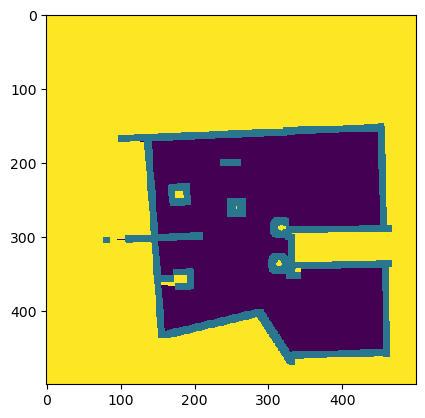

[ WARN] [1678664916.389136868]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2911.737000 according to authority unknown_publisher
[ WARN] [1678664916.390619062]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2911.737000 according to authority /pose_integrator
[ WARN] [1678664916.390665972]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2911.737000 according to authority /pose_integrator
[ WARN] [1678664916.390694413]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2911.737000 according to authority /pose_integrator
[ WARN] [1678664916.390718805]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2911.737000 according to authority /pose_integrator
[ WARN] [1678664944.801534894]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2915.009000 according to authority unknown_publisher
[ WARN] [1678664944.

In [190]:
contoured=cv2.drawContours(img_map.astype('uint8'), contours, 1, (255,255,255), 1)
plt.imshow(contoured[750:1250,750:1250])

In [149]:
robot.dtype

dtype('int64')

[2.3321864880638437, -0.47865903021689604, 0.0]
robot Pose (tf)


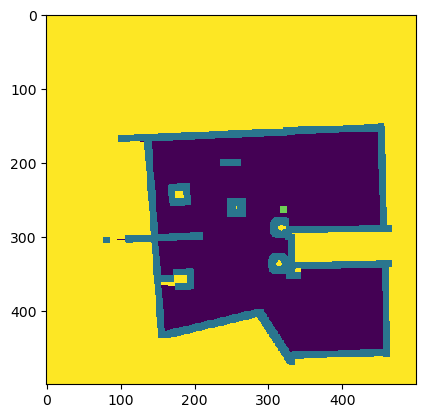

[ WARN] [1678663824.327547780]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2811.335000 according to authority unknown_publisher
[ WARN] [1678663824.329063457]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2811.335000 according to authority /pose_integrator
[ WARN] [1678663824.329130892]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2811.335000 according to authority /pose_integrator
[ WARN] [1678663824.329167265]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2811.335000 according to authority /pose_integrator
[ WARN] [1678663824.329220732]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2811.335000 according to authority /pose_integrator
[ WARN] [1678663828.151163448]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2811.708000 according to authority /pose_integrator
[ WARN] [1678663828.1

In [150]:
robot=get_robot_px()
draw_at(1024+robot[1],1024+robot[0],contoured)
plt.imshow(contoured[750:1250,750:1250])
print ('robot Pose (tf)')

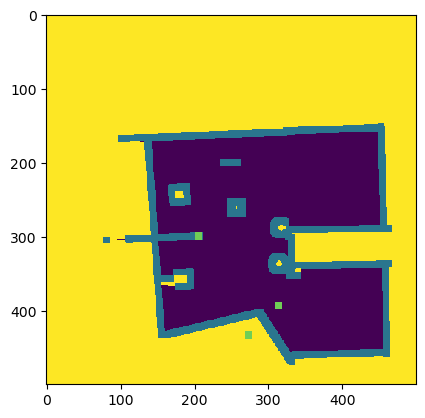

[ WARN] [1678659996.112771801]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2440.420000 according to authority /pose_integrator
[ WARN] [1678659996.113063243]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2440.420000 according to authority /pose_integrator
[ WARN] [1678659996.113134329]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2440.420000 according to authority /pose_integrator
[ WARN] [1678659996.113190373]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2440.420000 according to authority /pose_integrator
[ WARN] [1678659996.113716942]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2440.420000 according to authority unknown_publisher
[ WARN] [1678660001.514141096]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2441.031000 according to authority /pose_integrator
[ WARN] [1678660001.5

In [71]:
safe_xy_px=point_to_px(-3.4,1.3)


#draw_at(1024+ round(safe_
draw_at(1024 +safe_xy_px[1],1024+safe_xy_px[0],contoured)
plt.imshow(contoured[750:1250,750:1250])


In [159]:
safe_xy_px=point_to_px (x,y)
safe_xy_px

array([ -40, -200])

[2.335110251893277, -0.4807940628163633, 0.0]


array([200, -10])

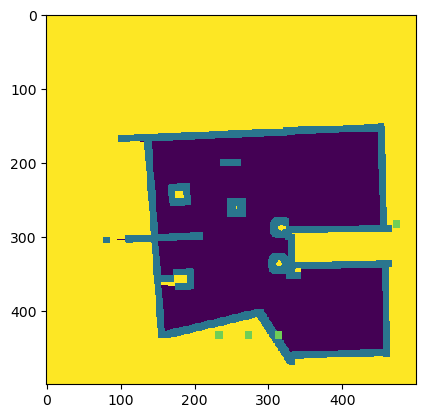

In [173]:
# Quiero saber punto 0,-7 m esta libre?
y=-0.5   ## MAP and pixels are not aligned
x=10

xrob,yrob=get_robot_px()
safe_xy=np.asarray((x,y))
safe_xy_px=point_to_px (x,y)
draw_at(1024-safe_xy_px[1],1024+ safe_xy_px[0],contoured)

plt.imshow(contoured[750:1250,750:1250])
safe_xy_px

In [174]:
delta_px=  safe_xy_px-np.asarray((xrob,yrob))
delta_px= (delta_px / np.linalg.norm(delta_px)).round()
delta_px

array([1., 0.])

[ WARN] [1678664313.354177345]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2856.802000 according to authority unknown_publisher
[ WARN] [1678664313.357454663]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2856.802000 according to authority /pose_integrator
[ WARN] [1678664313.357506330]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2856.802000 according to authority /pose_integrator
[ WARN] [1678664313.357541349]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2856.802000 according to authority /pose_integrator
[ WARN] [1678664313.357573219]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2856.802000 according to authority /pose_integrator
[ WARN] [1678664324.822570720]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2857.838000 according to authority /pose_integrator
[ WARN] [1678664324.8

[2.3370591894494908, -0.48167351320001145, 0.0]
[-2. 10.]
not safe at [  4 160] [0.2        8.00000012]
[2.3370591894494908, -0.48167351320001145, 0.0]
not safe at [  6. 150.] [0.3        7.50000011]
[2.3370591894494908, -0.48167351320001145, 0.0]
not safe at [  8. 140.] [0.40000001 7.0000001 ]
[2.3370591894494908, -0.48167351320001145, 0.0]
not safe at [ 11. 130.] [0.55000001 6.5000001 ]
[2.3370591894494908, -0.48167351320001145, 0.0]
not safe at [ 13. 120.] [0.65000001 6.00000009]
[2.3370591894494908, -0.48167351320001145, 0.0]
safe at [ 16. 110.] [0.80000001 5.50000008]


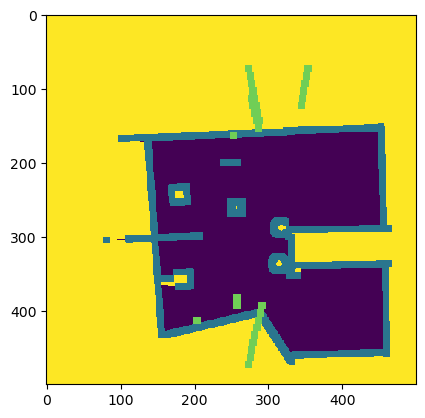

[ WARN] [1678665108.046769116]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2930.513000 according to authority /pose_integrator
[ WARN] [1678665108.046819986]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2930.513000 according to authority /pose_integrator
[ WARN] [1678665108.046854446]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2930.513000 according to authority /pose_integrator
[ WARN] [1678665108.046883170]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2930.513000 according to authority /pose_integrator
[ WARN] [1678665108.046932100]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2930.513000 according to authority unknown_publisher
[ WARN] [1678665120.784472007]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2932.034000 according to authority /pose_integrator
[ WARN] [1678665120.7

[ WARN] [1678665227.140074391]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2941.744000 according to authority unknown_publisher
[ WARN] [1678665227.145323786]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2941.744000 according to authority /pose_integrator
[ WARN] [1678665227.145422587]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2941.744000 according to authority /pose_integrator
[ WARN] [1678665227.145470135]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2941.744000 according to authority /pose_integrator
[ WARN] [1678665227.145517971]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2941.744000 according to authority /pose_integrator
[ WARN] [1678665232.605902515]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2942.392000 according to authority /pose_integrator
[ WARN] [1678665232.6

In [195]:
x,y=0.2,8
xrob,yrob=get_robot_px()
safe_xy=np.asarray((x,-1*y))
safe_xy_px=point_to_px (x,y)
delta_px=  safe_xy_px-np.asarray((xrob,yrob))
delta_px= delta_px / np.linalg.norm(delta_px).round()
delta_px=np.round(delta_px*10)
print (delta_px.round())
newxy=np.zeros(2)
for i in range(9):
    if (contoured[1024+ safe_xy_px[1].astype('int'),1024-safe_xy_px[0].astype('int')]!=0):   ## axis are twisted cause y sign
                print ('not safe at', safe_xy_px , safe_xy_px*pix_per_m)
                draw_at(1024-safe_xy_px[1].astype('int'),1024+ safe_xy_px[0].astype('int'),contoured)
                #draw_at(1024+safe_xy_px[1].astype('int'),1024- safe_xy_px[0].astype('int'),contoured)
                xrob,yrob=get_robot_px()
                delta_px=  safe_xy_px-np.asarray((xrob,yrob))
                delta_px= delta_px / np.linalg.norm(delta_px).round()
                delta_px=np.round(delta_px*10)
                
                
                newxy[0]=safe_xy_px[0]-delta_px[0].astype('int')
                newxy[1]=safe_xy_px[1]-delta_px[1].astype('int')
                safe_xy_px=newxy
    else:
            print ('safe at', safe_xy_px, safe_xy_px*pix_per_m)
            break
draw_at(1024+safe_xy_px[1].astype('int'),1024- safe_xy_px[0].astype('int'),contoured)
plt.imshow(contoured[750:1250,750:1250])

In [ ]:
 for t in range (3):
        if (contoured[1024+ round(safe_xy[0]/pix_per_m),1024- round(safe_xy[1]/pix_per_m)]!=0):   ## axis are twisted cause y sign
            delta=  safe_xy-np.asarray((xrob,yrob))
            delta= delta / np.linalg.norm(delta) 
            #print(delta,'delta')
            print ('not safe at', safe_xy,contoured[1024+ round(safe_xy[0]/pix_per_m),1024- round(safe_xy[1]/pix_per_m)])
            newxy[0]=safe_xy[0]+delta[0]
            newxy[1]=safe_xy[1]-delta[1]
            #print ('try', newxy)
            #draw_at(1024+ round(safe_xy[1]/pix_per_m),1024- round(safe_xy[0]/pix_per_m),contoured)##AXIS
            draw_at(1024+safe_xy_px[1],1024- safe_xy_px[0],contoured)
            safe_xy=newxy
        else:
            print ('safe at', safe_xy)
            break

In [79]:
# Quiero saber punto 0,-7 m esta libre?
y=8   ## MAP and pixels are not aligned
x=0
def check_point_map(x,y):
    ##meters, map (not pixels)
    xrob,yrob=get_robot()
    safe_xy=np.asarray((x,y))
    safe_xy_px=point_to_px (x,y)
    

    
    delta=  safe_xy-np.asarray((xrob,yrob))
    delta= delta / np.linalg.norm(delta)
    print (delta)
    
    delta_px=  safe_xy_px-np.asarray((xrob,yrob))
    delta_px= delta_px / np.linalg.norm(delta_px)
    print (delta_px)



    newxy=np.zeros(2)
    #print (delta)

    for t in range (3):
        if (contoured[1024+ round(safe_xy[0]/pix_per_m),1024- round(safe_xy[1]/pix_per_m)]!=0):   ## axis are twisted cause y sign
            delta=  safe_xy-np.asarray((xrob,yrob))
            delta= delta / np.linalg.norm(delta) 
            #print(delta,'delta')
            print ('not safe at', safe_xy,contoured[1024+ round(safe_xy[0]/pix_per_m),1024- round(safe_xy[1]/pix_per_m)])
            newxy[0]=safe_xy[0]+delta[0]
            newxy[1]=safe_xy[1]-delta[1]
            #print ('try', newxy)
            #draw_at(1024+ round(safe_xy[1]/pix_per_m),1024- round(safe_xy[0]/pix_per_m),contoured)##AXIS
            draw_at(1024+safe_xy_px[1],1024- safe_xy_px[0],contoured)
            safe_xy=newxy
        else:
            print ('safe at', safe_xy)
            break




[ WARN] [1678660403.331744359]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2476.360000 according to authority unknown_publisher
[ WARN] [1678660403.334429626]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2476.360000 according to authority /pose_integrator
[ WARN] [1678660403.334481003]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2476.360000 according to authority /pose_integrator
[ WARN] [1678660403.334508933]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2476.360000 according to authority /pose_integrator
[ WARN] [1678660403.334534620]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2476.360000 according to authority /pose_integrator


[0.4481991173588523, -0.987738132317624, 0.0]
[  9 -20]
[-0.03569153  0.99936285]
[-0.03569153  0.99936285] delta
not safe at [8 8] 200
[-0.03832985  0.99926514] delta
not safe at [7.96430847 7.00063715] 255
[-0.04127114  0.99914798] delta
not safe at [7.92597862 6.001372  ] 100
[-0.04456342  0.99900656] delta
not safe at [7.88470748 5.00222402] 100
[-0.04826454  0.99883459] delta
not safe at [7.84014406 4.00321746] 255
[-0.0524447   0.99862383] delta
not safe at [7.79187952 3.00438288] 255
[-0.05718967  0.99836333] delta
not safe at [7.73943482 2.00575905] 255
[-0.06260509  0.99803838] delta
not safe at [7.68224515 1.00739571] 255
[-0.06882215  0.99762894] delta
not safe at [7.61964006 0.00935734] 255
[-0.0760052   0.99710742] delta
not safe at [ 7.55081791 -0.98827161] 255
safe at [ 7.47481271 -1.98537903]


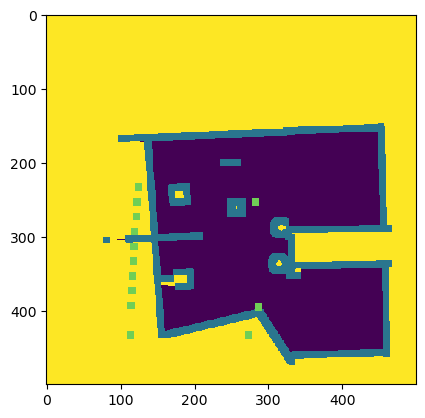

[ WARN] [1678650214.232972575, 2539.134000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2539.171000 according to authority /pose_integrator
[ WARN] [1678650214.233024068, 2539.134000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2539.171000 according to authority /pose_integrator
[ WARN] [1678650214.233049164, 2539.134000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2539.171000 according to authority /pose_integrator
[ WARN] [1678650214.233074390, 2539.134000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2539.171000 according to authority /pose_integrator
[ WARN] [1678650214.233236798, 2539.134000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2539.171000 according to authority unknown_publisher
[ WARN] [1678650225.870177073, 2540.109000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678650490.078436311, 2558.732000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2558.777000 according to authority /pose_integrator
[ WARN] [1678650490.078491835, 2558.732000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2558.777000 according to authority /pose_integrator
[ WARN] [1678650490.078517604, 2558.732000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2558.777000 according to authority /pose_integrator
[ WARN] [1678650490.078540777, 2558.732000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2558.777000 according to authority /pose_integrator
[ WARN] [1678650490.082631550, 2558.732000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2558.777000 according to authority unknown_publisher
[ WARN] [1678650506.328293383, 2559.655000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678650624.769016421, 2568.225000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2568.275000 according to authority /pose_integrator
[ WARN] [1678650624.769098350, 2568.225000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2568.275000 according to authority /pose_integrator
[ WARN] [1678650624.769129281, 2568.225000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2568.275000 according to authority /pose_integrator
[ WARN] [1678650624.769155979, 2568.225000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2568.275000 according to authority /pose_integrator
[ WARN] [1678650624.769563092, 2568.225000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2568.275000 according to authority unknown_publisher
[ WARN] [1678650627.988318818, 2568.501000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678650755.089350357, 2578.580000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2578.612000 according to authority unknown_publisher
[ WARN] [1678650755.098828773, 2578.580000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2578.612000 according to authority /pose_integrator
[ WARN] [1678650755.099897369, 2578.580000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2578.612000 according to authority /pose_integrator
[ WARN] [1678650755.100707546, 2578.580000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2578.612000 according to authority /pose_integrator
[ WARN] [1678650755.101056719, 2578.580000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2578.612000 according to authority /pose_integrator
[ WARN] [1678650772.059652112, 2580.172000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678650848.877972662, 2586.216000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2586.253000 according to authority unknown_publisher
[ WARN] [1678650848.881614832, 2586.216000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2586.253000 according to authority /pose_integrator
[ WARN] [1678650848.881665998, 2586.216000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2586.253000 according to authority /pose_integrator
[ WARN] [1678650848.881690206, 2586.216000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2586.253000 according to authority /pose_integrator
[ WARN] [1678650848.881710483, 2586.216000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2586.253000 according to authority /pose_integrator
[ WARN] [1678650864.418415533, 2587.399000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678650906.612541460, 2590.786000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2590.815000 according to authority /pose_integrator
[ WARN] [1678650906.612610413, 2590.786000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2590.815000 according to authority /pose_integrator
[ WARN] [1678650906.612637208, 2590.786000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2590.815000 according to authority /pose_integrator
[ WARN] [1678650906.612662640, 2590.786000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2590.815000 according to authority /pose_integrator
[ WARN] [1678650906.613373175, 2590.786000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2590.815000 according to authority unknown_publisher
[ WARN] [1678650911.042592256, 2591.060000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678651004.655270859, 2598.360000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2598.382000 according to authority /pose_integrator
[ WARN] [1678651004.655346713, 2598.360000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2598.382000 according to authority /pose_integrator
[ WARN] [1678651004.655374285, 2598.360000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2598.382000 according to authority /pose_integrator
[ WARN] [1678651004.655399785, 2598.360000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2598.382000 according to authority /pose_integrator
[ WARN] [1678651004.657174537, 2598.360000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2598.382000 according to authority unknown_publisher
[ WARN] [1678651007.369947035, 2598.602000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678651120.647477425, 2607.456000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2607.485000 according to authority unknown_publisher
[ WARN] [1678651120.647705044, 2607.456000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2607.485000 according to authority /pose_integrator
[ WARN] [1678651120.647923487, 2607.456000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2607.485000 according to authority /pose_integrator
[ WARN] [1678651120.647957111, 2607.456000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2607.485000 according to authority /pose_integrator
[ WARN] [1678651120.648010542, 2607.456000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2607.485000 according to authority /pose_integrator
[ WARN] [1678651124.356341420, 2607.651000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678651196.840652494, 2613.682000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2613.738000 according to authority /pose_integrator
[ WARN] [1678651196.840772936, 2613.682000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2613.738000 according to authority /pose_integrator
[ WARN] [1678651196.840827944, 2613.682000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2613.738000 according to authority /pose_integrator
[ WARN] [1678651196.840872535, 2613.682000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2613.738000 according to authority /pose_integrator
[ WARN] [1678651196.842667043, 2613.682000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2613.738000 according to authority unknown_publisher
[ WARN] [1678651207.392240249, 2614.536000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678651291.110258556, 2621.574000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2621.592000 according to authority /pose_integrator
[ WARN] [1678651291.110432167, 2621.574000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2621.592000 according to authority /pose_integrator
[ WARN] [1678651291.110467219, 2621.574000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2621.592000 according to authority /pose_integrator
[ WARN] [1678651291.110492995, 2621.574000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2621.592000 according to authority /pose_integrator
[ WARN] [1678651291.119814451, 2621.574000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2621.592000 according to authority unknown_publisher
[ WARN] [1678651297.069683695, 2622.082000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678651388.614101912, 2629.595000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2629.632000 according to authority unknown_publisher
[ WARN] [1678651388.619453792, 2629.595000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2629.632000 according to authority /pose_integrator
[ WARN] [1678651388.619552542, 2629.595000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2629.632000 according to authority /pose_integrator
[ WARN] [1678651388.619582295, 2629.595000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2629.632000 according to authority /pose_integrator
[ WARN] [1678651388.619609797, 2629.595000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2629.632000 according to authority /pose_integrator
[ WARN] [1678651437.601132319, 2633.353000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678651496.529848897, 2638.096000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2638.186000 according to authority /pose_integrator
[ WARN] [1678651496.529892566, 2638.096000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2638.186000 according to authority /pose_integrator
[ WARN] [1678651496.529916296, 2638.096000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2638.186000 according to authority /pose_integrator
[ WARN] [1678651496.529942185, 2638.096000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2638.186000 according to authority /pose_integrator
[ WARN] [1678651496.530162830, 2638.096000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2638.186000 according to authority unknown_publisher
[ WARN] [1678651516.501508798, 2640.164000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678651638.621778053, 2650.445000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2650.468000 according to authority unknown_publisher
[ WARN] [1678651638.622998603, 2650.445000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2650.468000 according to authority /pose_integrator
[ WARN] [1678651638.623104599, 2650.445000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2650.468000 according to authority /pose_integrator
[ WARN] [1678651638.623153099, 2650.445000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2650.468000 according to authority /pose_integrator
[ WARN] [1678651638.623186060, 2650.445000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2650.468000 according to authority /pose_integrator
[ WARN] [1678651642.685153645, 2650.693000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678651688.257301328, 2654.121000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2654.186000 according to authority unknown_publisher
[ WARN] [1678651688.257976142, 2654.121000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2654.186000 according to authority /pose_integrator
[ WARN] [1678651688.258037433, 2654.121000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2654.186000 according to authority /pose_integrator
[ WARN] [1678651688.258065611, 2654.121000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2654.186000 according to authority /pose_integrator
[ WARN] [1678651688.258090739, 2654.121000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2654.186000 according to authority /pose_integrator
[ WARN] [1678651697.221329034, 2654.769000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1678651745.737233559, 2658.722000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2658.747000 according to authority /pose_integrator
[ WARN] [1678651745.737282772, 2658.722000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2658.747000 according to authority /pose_integrator
[ WARN] [1678651745.737319088, 2658.722000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2658.747000 according to authority /pose_integrator
[ WARN] [1678651745.737344897, 2658.722000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2658.747000 according to authority /pose_integrator
[ WARN] [1678651745.737470204, 2658.722000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2658.747000 according to authority unknown_publisher
[ WARN] [1678651782.414935534, 2661.754000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [181]:
# Quiero saber punto 0,-7 m esta libre?
y=8   ## MAP and pixels are not aligned
x=8

xrob,yrob=get_robot()
print(np.asarray((xrob,yrob)))
safe_xy=np.asarray((x,y))
delta=  safe_xy-np.asarray((xrob,yrob))
delta= delta / np.linalg.norm(delta)
print (delta)



newxy=np.zeros(2)
#print (delta)

for t in range (34):
    if (contoured[1024+ round(safe_xy[0]/pix_per_m),1024- round(safe_xy[1]/pix_per_m)]!=0):   ## axis are twisted cause y sign
        delta=  safe_xy-np.asarray((xrob,yrob))
        delta= delta / np.linalg.norm(delta) 
        print(delta,'delta')
        print ('not safe at', safe_xy,contoured[1024+ round(safe_xy[0]/pix_per_m),1024- round(safe_xy[1]/pix_per_m)])
        newxy[0]=safe_xy[0]+delta[0]
        newxy[1]=safe_xy[1]-delta[1]
        #print ('try', newxy)
        draw_at(1024+ round(safe_xy[1]/pix_per_m),1024- round(safe_xy[0]/pix_per_m),contoured)##AXIS
        safe_xy=newxy
    else:
        print ('safe at', safe_xy)
        break
    
draw_at(1024+ round(safe_xy[1]/pix_per_m),1024- round(safe_xy[0]/pix_per_m),contoured)

plt.imshow(contoured[750:1250,750:1250])



In [143]:
contoured[1024+ round(safe_xy[0]/pix_per_m),1024+ round(safe_xy[1]/pix_per_m)]

0

[ WARN] [1678649212.622273044, 2474.732000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2474.758000 according to authority unknown_publisher
[ WARN] [1678649212.622430317, 2474.732000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2474.758000 according to authority /pose_integrator
[ WARN] [1678649212.622500914, 2474.732000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2474.758000 according to authority /pose_integrator
[ WARN] [1678649212.622534108, 2474.732000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2474.758000 according to authority /pose_integrator
[ WARN] [1678649212.622566264, 2474.732000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2474.758000 according to authority /pose_integrator


In [55]:
delta=  safe_xy-np.asarray((xrob,yrob))

[ WARN] [1678646863.850084700, 2323.085000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2323.115000 according to authority /pose_integrator
[ WARN] [1678646863.850128641, 2323.085000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2323.115000 according to authority /pose_integrator
[ WARN] [1678646863.850151251, 2323.085000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2323.115000 according to authority /pose_integrator
[ WARN] [1678646863.850171183, 2323.085000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2323.115000 according to authority /pose_integrator
[ WARN] [1678646863.851545175, 2323.085000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2323.115000 according to authority unknown_publisher
[ WARN] [1678646864.424464254, 2323.160000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [140]:
delta

array([0., 1.])

[ WARN] [1678578210.906983050, 2533.518000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2533.543000 according to authority unknown_publisher
[ WARN] [1678578210.915211922, 2533.518000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2533.543000 according to authority /pose_integrator
[ WARN] [1678578210.915299190, 2533.518000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2533.543000 according to authority /pose_integrator
[ WARN] [1678578210.915324091, 2533.518000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2533.543000 according to authority /pose_integrator
[ WARN] [1678578210.915346640, 2533.518000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2533.543000 according to authority /pose_integrator


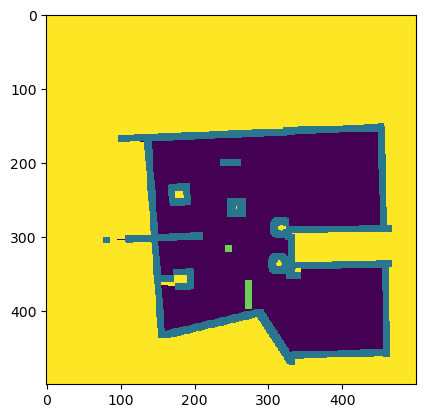

In [131]:
draw_at(1024+ round(safe_xy[0]/pix_per_m),1024+ round(safe_xy[1]/pix_per_m),contoured)
plt.imshow(contoured[750:1250,750:1250])


In [87]:
robot=get_robot()
y,x=(int)(robot[0]),(int)(robot[1])
y,x

[-1.3241845213801982, 2.1420530801051645, 0.0]


(-26, 43)

[ WARN] [1678577204.868103694, 2476.192000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2476.221000 according to authority unknown_publisher
[ WARN] [1678577204.873089633, 2476.192000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2476.221000 according to authority /pose_integrator
[ WARN] [1678577204.873420286, 2476.192000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2476.221000 according to authority /pose_integrator
[ WARN] [1678577204.873839664, 2476.192000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2476.221000 according to authority /pose_integrator
[ WARN] [1678577204.874046087, 2476.192000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2476.221000 according to authority /pose_integrator
[ WARN] [1678577211.502806514, 2476.632000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [54]:
origin=np.asarray((1024,1024))
deltax=round(round((safe_xy[1]-y)/pix_per_m)/round((safe_xy[0]+x)/pix_per_m)*10)
deltay=10

free 1008 1072 -0.800000011920929 2.400000035762787
free 1018 1077 -0.30000000447034836 2.650000039488077
free 1028 1082 0.20000000298023224 2.9000000432133675
free 1038 1087 0.7000000104308128 3.1500000469386578


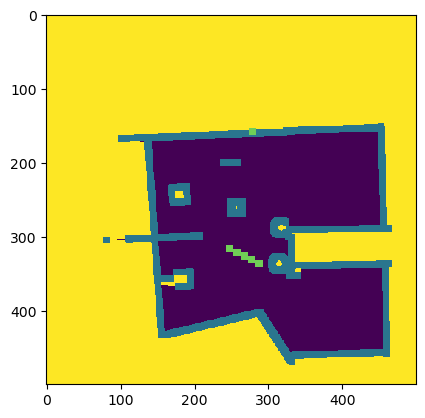

In [55]:
y,x=1024+(int)(robot[0]),1024+(int)(robot[1])

for i in range (100):
    if (contoured[y,x])==0 or (contoured[y,x])==200:
        y+=deltay
        x+=deltax
        draw_at(y,x,contoured)
        print('free',y,x,(y-1024)*pix_per_m, (x-1024)*pix_per_m)
plt.imshow(contoured[750:1250,750:1250])
    

In [75]:

y,x

(-46, 34)

[ WARN] [1678572936.436903094, 2364.849000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2364.869000 according to authority /pose_integrator
[ WARN] [1678572936.437004887, 2364.849000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2364.869000 according to authority /pose_integrator
[ WARN] [1678572936.437035536, 2364.849000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2364.869000 according to authority /pose_integrator
[ WARN] [1678572936.437060181, 2364.849000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2364.869000 according to authority /pose_integrator
[ WARN] [1678572936.442388994, 2364.849000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2364.869000 according to authority unknown_publisher


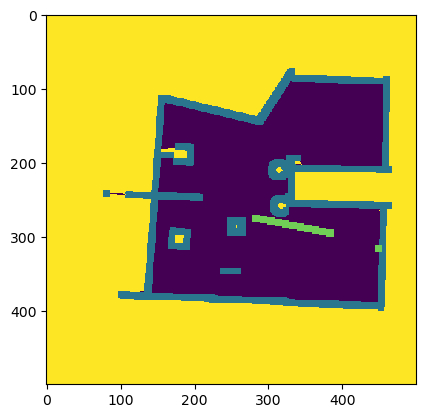

[ WARN] [1678572943.169188567, 2365.210000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2365.243000 according to authority /pose_integrator
[ WARN] [1678572943.169279312, 2365.210000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2365.243000 according to authority /pose_integrator
[ WARN] [1678572943.169326987, 2365.210000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2365.243000 according to authority /pose_integrator
[ WARN] [1678572943.169353442, 2365.210000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2365.243000 according to authority /pose_integrator
[ WARN] [1678572943.175041157, 2365.210000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2365.243000 according to authority unknown_publisher


In [76]:
plt.imshow(contoured[750:1250,750:1250])

In [77]:
contoured[y,x]

255

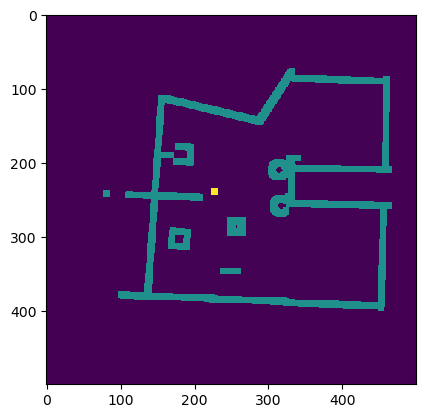

[ WARN] [1678572980.542467896, 2367.398000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2367.448000 according to authority unknown_publisher
[ WARN] [1678572980.544223238, 2367.398000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2367.448000 according to authority /pose_integrator
[ WARN] [1678572980.544310346, 2367.398000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2367.448000 according to authority /pose_integrator
[ WARN] [1678572980.544354132, 2367.398000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2367.448000 according to authority /pose_integrator
[ WARN] [1678572980.544378628, 2367.398000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2367.448000 according to authority /pose_integrator


In [78]:
robot=get_robot()
draw_at(1024+(int)(robot[0]),1024-(int)(robot[1]),img_flip)
plt.imshow (img_flip[750:1250,750:1250])


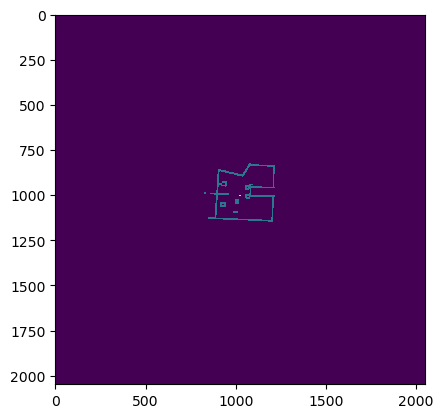

In [20]:
plt.imshow(img_flip)

In [49]:
data=img.data
w=img.info.width
h=img.info.height
resolution=img.info.resolution
Xstartx=img.info.origin.position.x
Xstarty=img.info.origin.position.y
 
ima= np.zeros((h, w, 1), np.uint8)

In [50]:

for i in range(0,h):
    for j in range(0,w):
        if data[i*w+j]==100:
            ima[i,j]=0
        elif data[i*w+j]==0:
            ima[i,j]=255
        elif data[i*w+j]==-1:
            ima[i,j]=205

In [71]:
o=cv2.inRange(ima,0,1)
edges = cv2.Canny(ima,0,255)

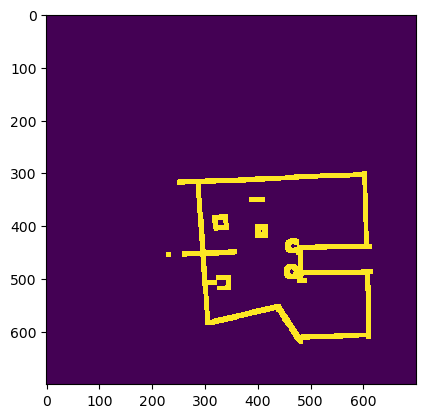

In [72]:
plt.imshow(o[600:1300,600:1300])

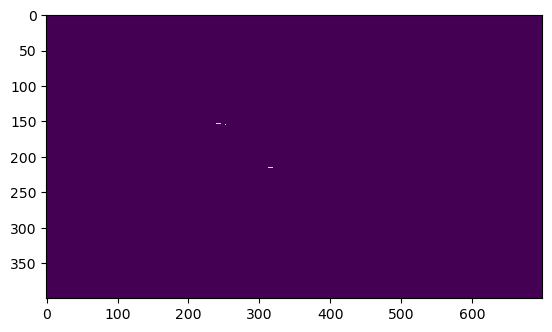

In [73]:
o=cv2.inRange(ima,0,1)
edges = cv2.Canny(ima,0,255)
contours, hierarchy = cv2.findContours(o,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(o, contours, -1, (255,255,255), 5)
o=cv2.bitwise_not(o) 
res = cv2.bitwise_and(o,edges)
plt.imshow(res[900:1300,600:1300])

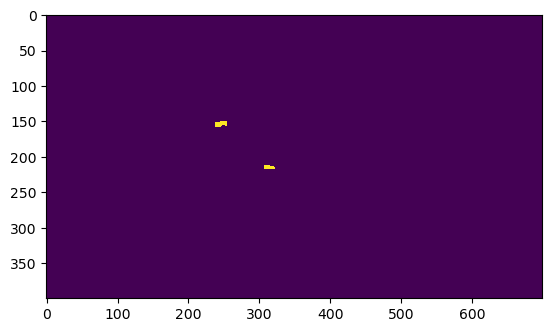

In [74]:
o=cv2.inRange(ima,0,1)
edges = cv2.Canny(ima,0,255)
contours, hierarchy = cv2.findContours(o,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(o, contours, -1, (255,255,255), 5)
o=cv2.bitwise_not(o) 
res = cv2.bitwise_and(o,edges)

frontier=np.copy(res)
contours, hierarchy = cv2.findContours(frontier,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(frontier, contours, -1, (255,255,255), 2)
contours, hierarchy = cv2.findContours(frontier,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
aa=cv2.drawContours(frontier, contours, -1, (255,255,255), 2)
plt.imshow(aa[900:1300,600:1300])

In [55]:
contours, hierarchy = cv2.findContours(frontier,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

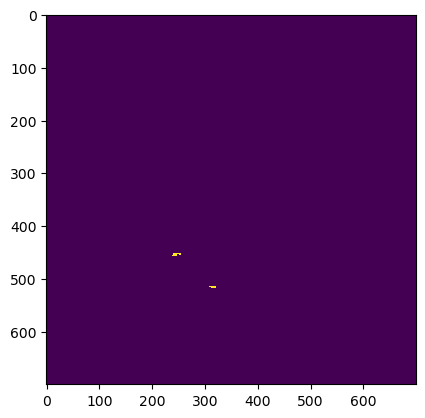

In [56]:
plt.imshow(frontier[600:1300,600:1300])


In [61]:
all_pts=[]
if len(contours)>0:
    upto=len(contours)-1
    i=0
    maxx=0
    maxind=0
        
    for i in range(0,len(contours)):
            cnt = contours[i]
            M = cv2.moments(cnt)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            xr=cx*resolution+Xstartx
            yr=cy*resolution+Xstarty
            pt=[np.array([xr,yr])]
            if len(all_pts)>0:
                all_pts=np.vstack([all_pts,pt])
            else:

                all_pts=pt
all_pts

array([[-5.52499732,  4.52500283],
       [-8.97499737,  1.47500279]])

In [82]:
def get_frontier(img):
    data=img.data
    w=img.info.width
    h=img.info.height
    resolution=img.info.resolution
    Xstartx=img.info.origin.position.x
    Xstarty=img.info.origin.position.y

    ima= np.zeros((h, w, 1), np.uint8)
    for i in range(0,h):
        for j in range(0,w):
            if data[i*w+j]==100:
                ima[i,j]=0
            elif data[i*w+j]==0:
                ima[i,j]=255
            elif data[i*w+j]==-1:
                ima[i,j]=205
    o=cv2.inRange(ima,0,1)
    edges = cv2.Canny(ima,0,255)
    contours, hierarchy = cv2.findContours(o,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(o, contours, -1, (255,255,255), 5)
    o=cv2.bitwise_not(o) 
    res = cv2.bitwise_and(o,edges)
    frontier=np.copy(res)
    contours, hierarchy = cv2.findContours(frontier,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frontier, contours, -1, (255,255,255), 2)
    contours, hierarchy = cv2.findContours(frontier,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    all_pts=[]
    if len(contours)>0:
        upto=len(contours)-1
        i=0
        maxx=0
        maxind=0

        for i in range(0,len(contours)):
                cnt = contours[i]
                M = cv2.moments(cnt)
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                xr=cx*resolution+Xstartx
                yr=cy*resolution+Xstarty
                pt=[np.array([xr,yr])]
                if len(all_pts)>0:
                    all_pts=np.vstack([all_pts,pt])
                else:

                    all_pts=pt
    return all_pts

                
                
                
    



In [90]:
frontiers=get_frontier(img)

In [117]:
def index_of_point(mapData, Xp):
    resolution = mapData.info.resolution
    Xstartx = mapData.info.origin.position.x
    Xstarty = mapData.info.origin.position.y
    width = mapData.info.width
    Data = mapData.data
    index = int((np.floor((Xp[1]-Xstarty)/resolution) *width)+(np.floor((Xp[0]-Xstartx)/resolution)))
    return index


In [125]:
def point_of_index(mapData, i):
    y = mapData.info.origin.position.y + \
        (i//mapData.info.width)*mapData.info.resolution
    x = mapData.info.origin.position.x + \
        (i-(i//mapData.info.width)*(mapData.info.width))*mapData.info.resolution
    return np.array([x, y])

In [118]:
def informationGain(mapData, point, r):
    infoGain = 0
    index = index_of_point(mapData, point)
    r_region = int(r/mapData.info.resolution)
    init_index = index-r_region*(mapData.info.width+1)
    for n in range(0, 2*r_region+1):
        start = n*mapData.info.width+init_index
        end = start+2*r_region
        limit = ((start/mapData.info.width)+2)*mapData.info.width
        for i in range(start, end+1):
            if (i >= 0 and i < limit and i < len(mapData.data)):
                if(mapData.data[i] == -1 and np.linalg.norm(np.array(point)-point_of_index(mapData, i)) <= r):
                    infoGain += 1
    return infoGain*(mapData.info.resolution**2)

In [119]:
from copy import copy
from sklearn.cluster import MeanShift
centroids=[]
front =copy(frontiers)
if len(front) > 1:
    ms = MeanShift(bandwidth=0.3)
    ms.fit(front)
    centroids = ms.cluster_centers_  # centroids array is the centers of each cluster

    # if there is only one frontier no need for clustering, i.e. centroids=frontiers
if len(front) == 1:
    centroids = front
    frontiers = copy(centroids)



In [120]:
centroids,frontiers


(array([[-5.52499732,  4.52500283],
        [-8.97499737,  1.47500279]]),
 array([[-5.52499732,  4.52500283],
        [-8.97499737,  1.47500279]]))

In [126]:
infoGain=[]
info_radius=1
for ip in range(0,len(centroids)):
    infoGain.append(informationGain(img,[centroids[ip][0],centroids[ip][1]],info_radius))

In [127]:
infoGain

[0.5225000155717135, 2.6200000780820853]

[ WARN] [1678572200.210830356, 2320.759000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2320.817000 according to authority /pose_integrator
[ WARN] [1678572200.210942671, 2320.759000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2320.817000 according to authority /pose_integrator
[ WARN] [1678572200.210976094, 2320.759000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2320.817000 according to authority /pose_integrator
[ WARN] [1678572200.211002779, 2320.759000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2320.817000 according to authority /pose_integrator
[ WARN] [1678572200.215158266, 2320.759000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2320.817000 according to authority unknown_publisher


In [191]:
get_robot()
origin + get_robot

TypeError: unsupported operand type(s) for +: 'int' and 'function'

In [192]:
origin+(robot/pix_per_m).round()


array([ 104., 1704.])

In [3]:
import rospy

In [ ]:
from vis